In [115]:
from models.perplexity import perplexity
from models.discrepancy import Detectorbydisc
from models.Dataset import Dataset
from models.evaluate import evaluate
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
%reload_ext autoreload

In [ ]:
text = "Yesterday, a man named Jack said he saw an alien. The alien was huge."
detectdisc=Detectorbydisc(threshold=0)

In [3]:
detectdisc.get_discrepancy(text,show_perturb=True,show_discrepancy=True)

Yesterday, a man named Jack said he saw an alien
yesterday, a boy named jack told he saw an alien
yesterday, an boy named jack told he saw an alien
yesterday, some guy named jack said he saw an alien
yesterday, an someone named jack said he saw an alien
yesterday, our man named jack called he saw an alien
The alien was huge
the thing was huge
the entity was huge
the creature was huge
the aliens was huge
the creature was huge
the discrepancy is -1.3547675609588623


-1.3547675609588623

In [8]:
data=Dataset(0,'./Dataset/intro1.csv')
data.make_batch(25,1)

In [ ]:
score=[]
for i in thresholds:
    model=Detectorbydisc(threshold=i)
    model.eval=True
    score.append(evaluate(model,data.batches[0]))

In [ ]:
model=Detectorbydisc(threshold=-3)
model.eval=True
score.append(evaluate(model,data.batches[0]))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
score

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.56, 0.52, 0.52]

In [ ]:
print(f'-2.5->0.56')
print(f'-2.7->0.52')
print(f'-2.8->0.52')


-2.5->0.56
-2.7->0.52


In [34]:
model2 = perplexity(separately=True)
print(
    model2(
        """
Perplexity is a concept borrowed from information theory and probability theory, and it serves as a quantitative measure of how well a language model predicts a sequence of words. In simple terms, perplexity reflects how surprised or uncertain a model is when faced with new data. The lower the perplexity, the better the model is at predicting the next word in a sequence."""
    )
)

41.333333333333336
0


In [74]:
ppl0=perplexity(separately=False)
ppl1=perplexity(separately=True)

In [82]:
data.make_batch(100, 1)
human = data.batches[1].data["wiki_intro"]
AI = data.batches[1].data["generated_intro"]


def calculate_ppl(model, data):
    ppls = []
    for item in data:
        _,ppl = model(item)
        ppls.append(ppl)
    return ppls

In [83]:
AI_ppl0 = calculate_ppl(ppl0, AI)
human_ppl0 = calculate_ppl(ppl0, human)
AI_ppl1 = calculate_ppl(ppl1, AI)
human_ppl1 = calculate_ppl(ppl1, human)

In [89]:
len(AI_ppl0)

100

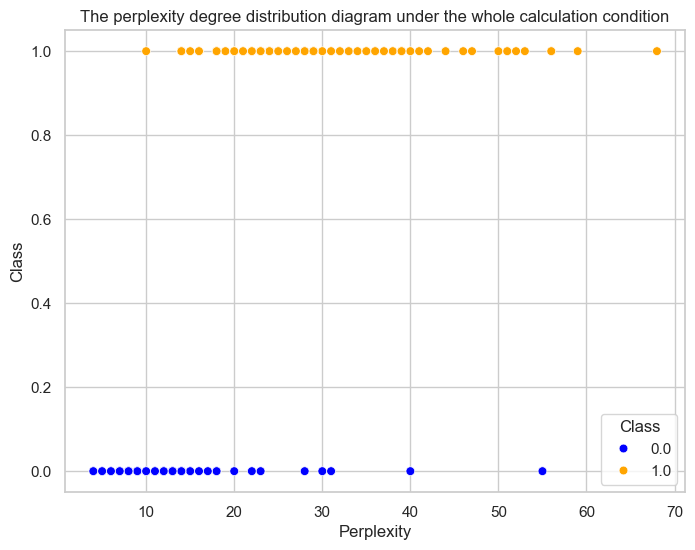

In [105]:
ppl0df = pd.DataFrame()
labelAI0 = torch.zeros(len(AI_ppl0)).tolist()
labelhuman0 = torch.ones(len(human_ppl0)).tolist()
ppl0df["Class"] = labelAI0+labelhuman0
ppl0df["Perplexity"] = AI_ppl0+human_ppl0
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="Perplexity",
    y="Class",
    hue="Class",
    data=ppl0df,
    palette={0: "blue", 1: "orange"},
    marker="o",
    s=40,
)
plt.legend(title="Class")
plt.title("The perplexity degree distribution diagram under the whole calculation condition")
plt.xlabel("Perplexity")
plt.ylabel("Class")
plt.show()

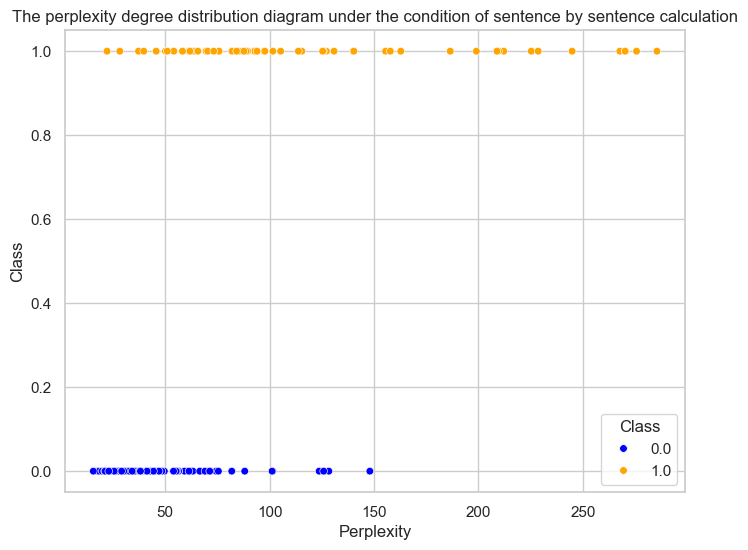

In [119]:
ppl1df = pd.DataFrame()
AI_ppl1 = [x for x in AI_ppl1 if not np.isnan(x) and x<300]
human_ppl1 = [x for x in human_ppl1 if not np.isnan(x) and x<300]

labelAI1 = torch.zeros(len(AI_ppl1)).tolist()
labelhuman1 = torch.ones(len(human_ppl1)).tolist()

ppl1df["Class"] = labelAI1+labelhuman1
ppl1df["Perplexity"] = AI_ppl1+human_ppl1
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="Perplexity",
    y="Class",
    hue="Class",
    data=ppl1df,
    palette={0: "blue", 1: "orange"},
    marker="o",
    s=30,
)
plt.legend(title="Class")
plt.title("The perplexity degree distribution diagram under the condition of sentence by sentence calculation")
plt.xlabel("Perplexity")
plt.ylabel("Class")
plt.show()


In [122]:
def calculate_accuracy(threshold,ppl,label):
    predicted=np.array([1 if x>threshold else 0 for x in ppl])
    actual = np.array(label)
    accuracy = np.mean(predicted == actual)
    return accuracy

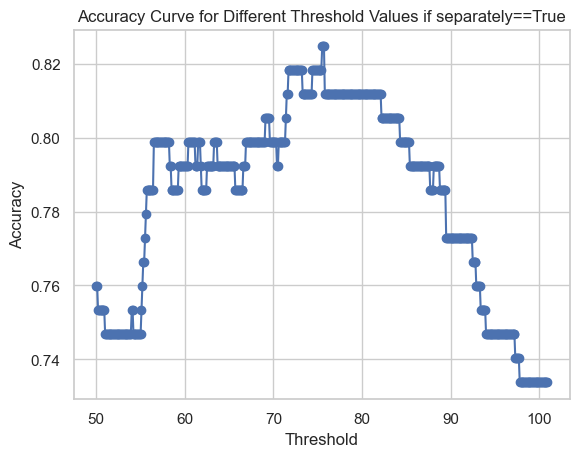

In [138]:
threshold_values = np.arange(50, 101, 0.1)
accuracy_values = [
    calculate_accuracy(threshold, ppl1df["Perplexity"], ppl1df["Class"])
    for threshold in threshold_values
]
best_threshold1 = threshold_values[np.argmax(accuracy_values)]
best_accuracy1 = max(accuracy_values)
plt.plot(threshold_values, accuracy_values, marker="o")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve for Different Threshold Values if separately==True")
plt.grid(True)
plt.show()

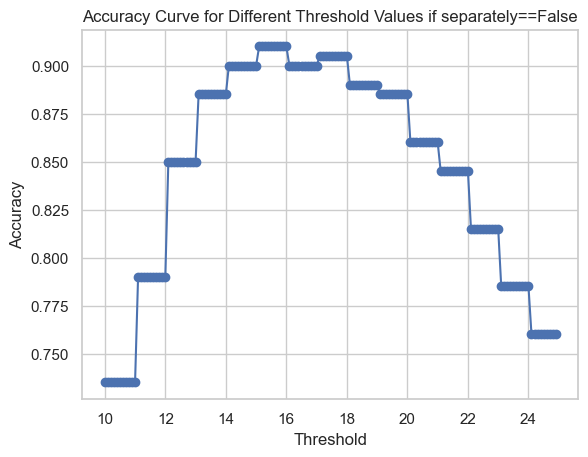

In [147]:
threshold_values = np.arange(10, 25, 0.1)
accuracy_values = [
    calculate_accuracy(threshold, ppl0df["Perplexity"], ppl0df["Class"])
    for threshold in threshold_values
]
best_threshold0 = threshold_values[np.argmax(accuracy_values)]
best_accuracy0 = max(accuracy_values)
plt.plot(threshold_values, accuracy_values, marker="o")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve for Different Threshold Values if separately==False")
plt.grid(True)
plt.show()

In [145]:
print(best_accuracy0,int(best_threshold0))
print(round(best_accuracy1,2),int(best_threshold1))


0.91 15
0.82 75


Having optimize the parameters , now let's evaluate them by testset.

In [149]:
finalppl0=perplexity(threshold=15,separately=False)
finalppl1=perplexity(threshold=75,separately=True)
accuracy0=evaluate(finalppl0,data.batches[0])
accuracy1=evaluate(finalppl1,data.batches[0])
print(accuracy0,accuracy1)

0.88 0.84
